In [4]:
import numpy as np
import pygabor.spectrogram
from importlib import reload

In [2]:
reload(pygabor.spectrogram)

<module 'pygabor.spectrogram' from 'c:\\Users\\E7450\\miniconda3\\envs\\Lib\\site-packages\\pygabor\\spectrogram.py'>

In [5]:
import pickle

# Load the banshee.pkl file
with open('banshee.pkl', 'rb') as file:
    banshee = pickle.load(file)

In [12]:
# Generate a synthetic test signal with a harmonic spectrum
#harmonic, samplfreq = pygabor.spectrogram.harmonictestsignal()
harmonic = banshee[:8000]
samplfreq = 8000
freqs = pygabor.spectrogram.auditory_frequencies(fmin = 200, fmax = 4000, numperoctave= 100)

stddevs = np.full(len(freqs), 0.01)
import matplotlib.pyplot as plt


def normalize_to_unit(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min + 1e-10)  

In [13]:
def showlog(
        spectrogram : pygabor.spectrogram.Spectrogram,
        lowsoftthresh : float = 0.000001,
        maxrange : float = 60):
    """Computes the logarithm of the absolute value of a spectrogram 
and displays it
"""
    # Compute the absolute value of the spectrogram
    absspectrogram = np.sqrt(spectrogram.coscomp**2 + spectrogram.sincomp**2)
    absspectrogram = normalize_to_unit(absspectrogram)
    # Compute logarithmic magnitudes in dB, with additional lower bound
    maxval = np.max(absspectrogram)
    logspectrogram = 20 * np.log10(absspectrogram/maxval + lowsoftthresh)
    logspectrogram[logspectrogram < -maxrange] = -maxrange

    midi = pygabor.spectrogram.midifromfreq(spectrogram.frequencies)
    freqs = spectrogram.frequencies
    log_freqs = np.geomspace(200, freqs[-1], num=300)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]    
    ytick_labels = [f"{int(f)}" for f in subsampled_y_values]
    extent=[0, 1, 0,len(freqs)]

    window_size = 500
    hop_size = 10
    fs = 8000
    
    num_frames = 1 + (8000 - window_size) // hop_size

    time = np.arange(num_frames) * hop_size / fs
    plt.figure(figsize=(14, 7))
    im = \
      plt.imshow(logspectrogram, \
                 cmap='jet', interpolation='nearest', aspect='auto', \
                 origin='lower', 
                 extent=extent)
                 #extent=[0, spectrogram.duration, min(spectrogram.frequencies), max(spectrogram.frequencies)],)
    #plt.pcolormesh(time, freqs, logspectrogram, shading='gouraud', cmap='jet', vmin=-maxrange, vmax=0)
    
    cbar = plt.colorbar(label='Magnitude')
    #cbar.set_ticks(np.linspace(0, 1, num=6))
    cbar.set_ticklabels([f"{x:.1f}" for x in np.linspace(0, 1, num=7)])
    #plt.yscale('log')
    plt.yticks(subsampled_indices, ytick_labels)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# --- Parameters ---
fs = 8000
duration = 1.0
n_samples = int(fs * duration)
frequencies = [0.003, 0.005, 0.0075, 0.01]
frequencies.reverse()  # cycles/sample
n_segments = 20
segment_len = n_samples // n_segments
t = np.arange(n_samples)

# --- Generate synthetic signal with random frequency segments ---
rng = np.random.default_rng(42)
signal = np.zeros(n_samples)
masks = {f: np.zeros(n_samples, dtype=bool) for f in frequencies}

for i in range(n_segments):
    start = i * segment_len
    end = start + segment_len
    t_seg = np.arange(segment_len)
    
    # Weighted selection to make 0.003 less likely
    weights = [0.2 if f == 0.003 else 1.0 for f in frequencies]
    prob = np.array(weights) / np.sum(weights)

    n_freqs = rng.integers(0, len(frequencies)+1)
    freqs_here = rng.choice(frequencies, size=n_freqs, replace=False, p=prob)

    segment = np.zeros(segment_len)
    for f in freqs_here:
        segment += np.sin(2 * np.pi * f * t_seg)
        masks[f][start:end] = True
    segment *= np.hanning(segment_len)
    signal[start:end] += segment


signal /= np.max(np.abs(signal))
signal += 0.00 * rng.normal(size=n_samples)


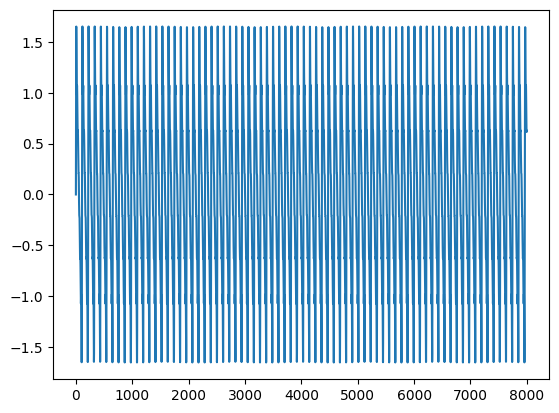

In [34]:
harmonic, samplfreq = pygabor.spectrogram.harmonictestsignal()
plt.plot(harmonic[:8000])

C:\Users\E7450\AppData\Local\Temp\ipykernel_15760\3969197104.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f"{x:.1f}" for x in np.linspace(0, 1, num=7)])


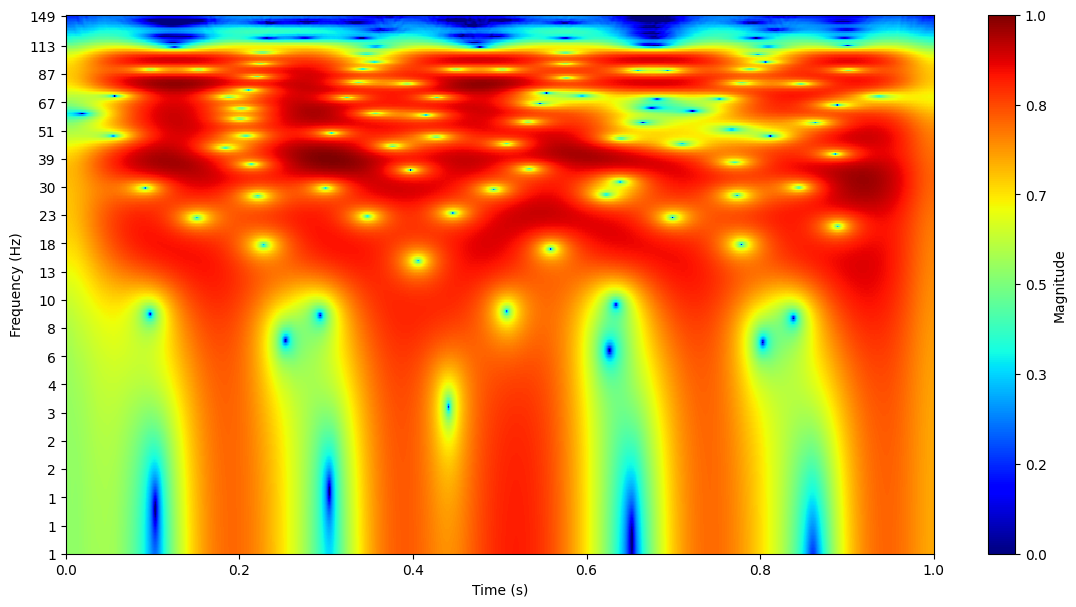

In [37]:
freqs = pygabor.spectrogram.auditory_frequencies(fmin = 1, fmax = 150, numperoctave= 50)
stddevs = np.full(len(freqs), 1)
samplfreq = 8000
# Compute spectrogram based on the time-causal analogue of the Gabor transform for distribution parameter c = sqrt(2)
spectr1 = pygabor.spectrogram.auditory_spectrogram(signal, samplfreq, 'discgabor',frequencies=freqs)
#showlog(spectr1, lowsoftthresh=0.000001, maxrange=60)

In [41]:
freqs = pygabor.spectrogram.auditory_frequencies(fmin = 10, fmax = 150, numperoctave= 50)
stddevs = np.full(len(freqs), 1)

spectrogram = pygabor.spectrogram.auditory_spectrogram(signal, samplfreq, 'discgabor',frequencies=freqs,stddevs = stddevs)
absspectrogram = np.sqrt(spectrogram.coscomp**2 + spectrogram.sincomp**2)
absspectrogram = normalize_to_unit(absspectrogram)
plt.imshow(absspectrogram, cmap='jet', interpolation='nearest', aspect='auto', origin='lower')

KeyboardInterrupt: 

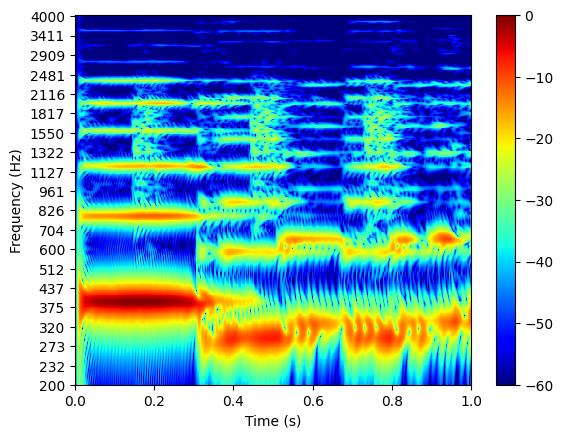

In [126]:
# Compute spectrogram based on the time-causal analogue of the Gabor transform for distribution parameter c = 2
spectr2 = pygabor.spectrogram.auditory_spectrogram(harmonic, samplfreq, 'timecausgabor-c2',frequencies=freqs,stddevs=stddevs)
showlog(spectr2)

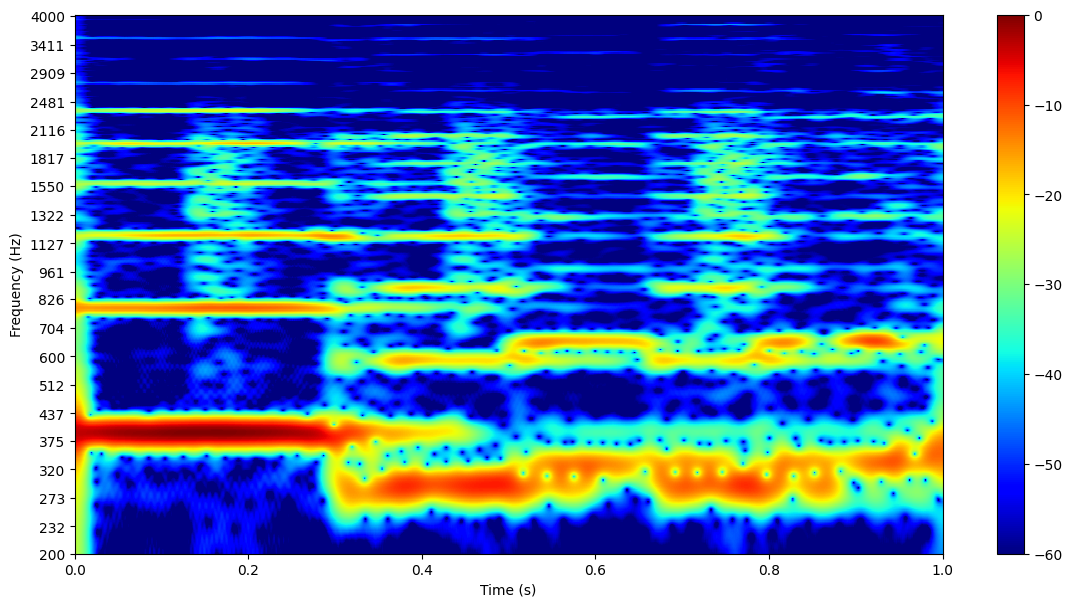

In [143]:
# Compute spectrogram based on the regular Gabor transform, using the 
# discrete analogue of the Gaussian kernel for discrete approximation
# of the continuous Gaussian kernel
spectr3 = pygabor.spectrogram.auditory_spectrogram(harmonic, samplfreq, 'discgabor',frequencies=freqs,stddevs=stddevs)
showlog(spectr3)

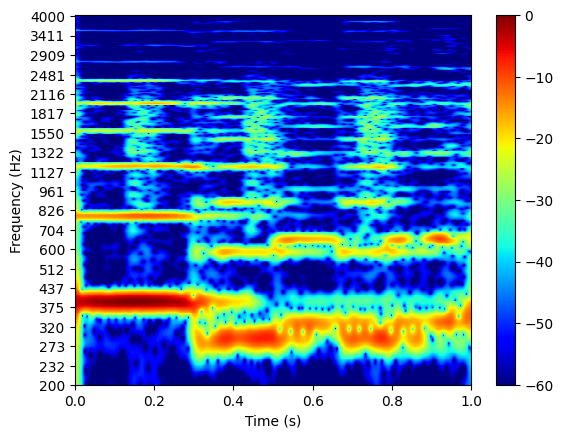

In [123]:
# Compute spectrogram based on the regular Gabor transform, using the 
# sampled Gaussian kernel for discrete approximation of the continuous 
# Gaussian kernel
spectr4 = pygabor.spectrogram.auditory_spectrogram(harmonic, samplfreq, 'samplgabor',frequencies=freqs,stddevs=stddevs)
showlog(spectr4)